<a href="https://colab.research.google.com/github/ml2-picme/PicMe/blob/master/Model%20Comparison_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Methodendefinitionen

In [0]:
# Install the PyDrive wrapper & import libraries
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os
from keras.applications.vgg16 import VGG16, preprocess_input

from PIL import Image
import numpy as np

from keras.applications.vgg16 import decode_predictions
import matplotlib.pyplot as plt

#import plotly.plotly as plotly

from plotly.offline import download_plotlyjs, init_notebook_mode, plot,iplot
import plotly.graph_objs as go

# Define the Methods

localFilePath = "/root/data"

def reloadPictures():
  # Authenticate and create the PyDrive client
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)

  # Delete the local directory
  !rm -r $localFilePath
  print("Deleted local directory")

  # Set a local directory and upload files from Google Drive
  local_root_path = os.path.expanduser(localFilePath)
  try:
    os.makedirs(local_root_path)
  except: pass

  def ListFolder(google_drive_id, destination):
    file_list = drive.ListFile({'q': "'%s' in parents and trashed=false" % google_drive_id}).GetList()
    counter = 0
    for f in file_list:
      # If it is a directory then, create the dicrectory and upload the file inside it
      if f['mimeType']=='application/vnd.google-apps.folder': 
        folder_path = os.path.join(destination, f['title'])
        os.makedirs(folder_path)
        print('* creating directory {}'.format(folder_path))
        ListFolder(f['id'], folder_path)
      else:
        fname = os.path.join(destination, f['title'])
        f_ = drive.CreateFile({'id': f['id']})
        f_.GetContentFile(fname)
        counter += 1
    print('* {} files were uploaded in {}'.format(counter, destination))

  # Opening and uploading the Drive Folder => this is the shared directory and should work for everyone who belongs to the project
  print("\nCalling the ListFolder method, that uploads the data...")
  ListFolder("1M7TDDTFoNOjsrlEMonWN858uQONUp9Pz", local_root_path)
  print("Upload finished!")

  # Show the Data in the local Path
  print("\nListing files in local test directory")
  !ls -l $localFilePath
  
  
def createFileList():
  files = []
  # r=root, d=directories, f = files
  for r, d, f in os.walk(localFilePath):
      for file in f:
          if file.endswith(".jpg"):
              files.append(os.path.join(r, file))

  print("Printing files:")

  for f in files:
      print(f)
      
  return files

def prepareImagesForClassification(files):
  
  images = []
  
  for file in files:
    try:
      image = Image.open(file)
      
       #for Inception images need a size of 299x299
        
      # image = image.resize((299, 299), Image.LANCZOS)
      
      image = image.resize((224, 224), Image.LANCZOS)
      
      image = image.convert("RGB")
      
      image = np.asarray(image)
      
      images.append(image)
    except OSError:
      pass
  
  images = np.asarray(images)
  
  return images

def classifyImages(images, model):
  
  # preprocess the images to fit to the model
  images_preprocessed = preprocess_input(images)
  
  # use the model to classifi the images
  images_pred = model.predict(images_preprocessed, verbose=1)
  
  pred_results = decode_predictions(images_pred)
  
  return pred_results

def printResults(images, predictedClasses):
  
  for i in range(len(images)):
    plt.figure()
    plt.imshow(images[i])
    plt.title(predictedClasses[i])
    plt.axis('off')
    
  plt.show()
  
def compareResults(fileNames, resulsList1, modelList1, threshold):
  
  for i in range(len(fileNames)):
    print("Comparing the Results for File: " + fileNames[i])
    
    for j in range(5):
      
      for k in range(len(modelList1)):
        
        resultToPrint = resultsList1[k][i][j]
        
        # Setze 5% als Threshold
        if(resultToPrint is not None and resultToPrint[2] > threshold):
          print(" > ", (j+1), ". Platz @ ", modelList1[k], " : ", resultsList1[k][i][j])
        else:
          print(" > ", (j+1), ". Platz @ ", modelList1[k], " : ", "--- Threshold-Filter ---")
      
      print("=================================================================")
      
    print("")

## Dateien übertragen -> einmal bei Session Start ausführen (bzw. bei neuen Bildern im Drive)

In [15]:
# Lade die Bilder erneut + File Preparation -> einmal beim Session Start ausführen
reloadPictures()
foundFiles = createFileList()
preparedImages = prepareImagesForClassification(foundFiles)




Deleted local directory

Calling the ListFolder method, that uploads the data...
* 11 files were uploaded in /root/data
Upload finished!

Listing files in local test directory
total 1636
-rw-r--r-- 1 root root 106647 Apr  8 12:57 auto.jpg
-rw-r--r-- 1 root root 204846 Apr  8 12:57 berge.jpg
-rw-r--r-- 1 root root 305634 Apr  8 12:57 bora-bora.jpg
-rw-r--r-- 1 root root 104237 Apr  8 12:57 brücke.jpg
-rw-r--r-- 1 root root 118569 Apr  8 12:57 handy.jpg
-rw-r--r-- 1 root root  51903 Apr  8 12:57 hund.jpg
-rw-r--r-- 1 root root  59945 Apr  8 12:57 katze.jpg
-rw-r--r-- 1 root root  53904 Apr  8 12:57 papagei.jpg
-rw-r--r-- 1 root root 204156 Apr  8 12:57 rose.jpg
-rw-r--r-- 1 root root  97310 Apr  8 12:57 sandwich.jpg
-rw-r--r-- 1 root root 346140 Apr  8 12:57 waffe.jpg
Printing files:
/root/data/katze.jpg
/root/data/waffe.jpg
/root/data/sandwich.jpg
/root/data/rose.jpg
/root/data/papagei.jpg
/root/data/auto.jpg
/root/data/bora-bora.jpg
/root/data/handy.jpg
/root/data/brücke.jpg
/root/data

## Bildklassifikation mit verschiedenen Modellen

11/11 [==============================] - 30s 3s/step


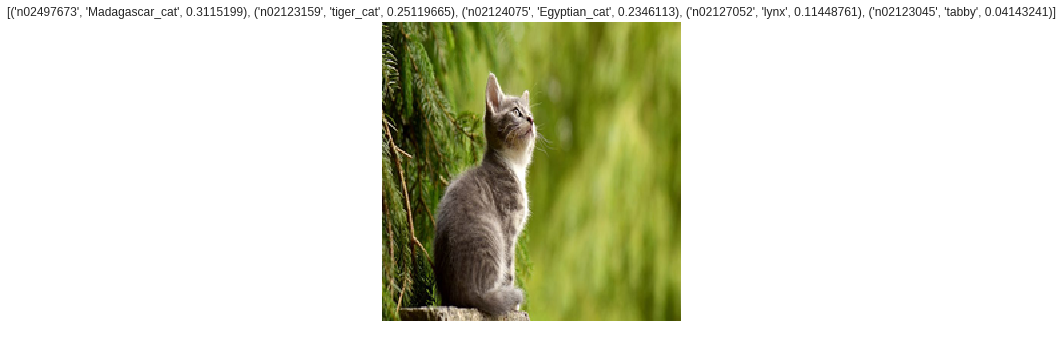

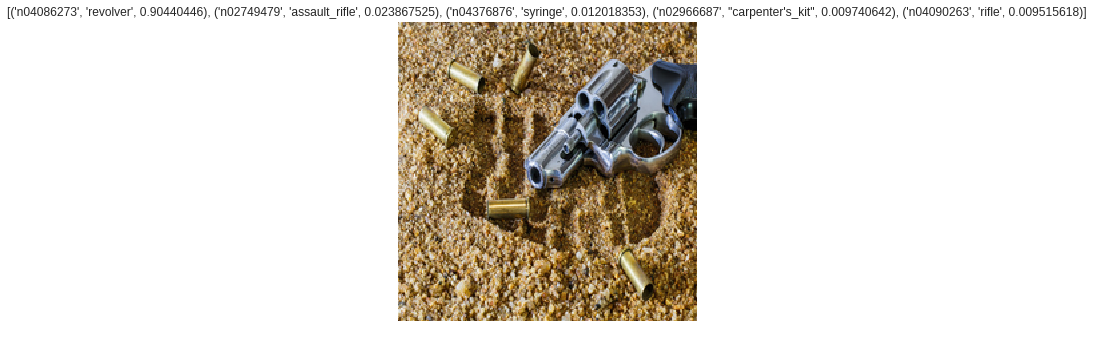

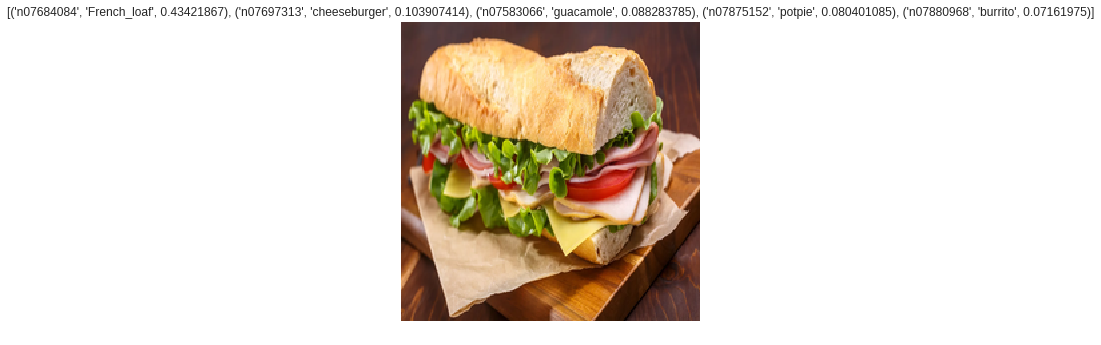

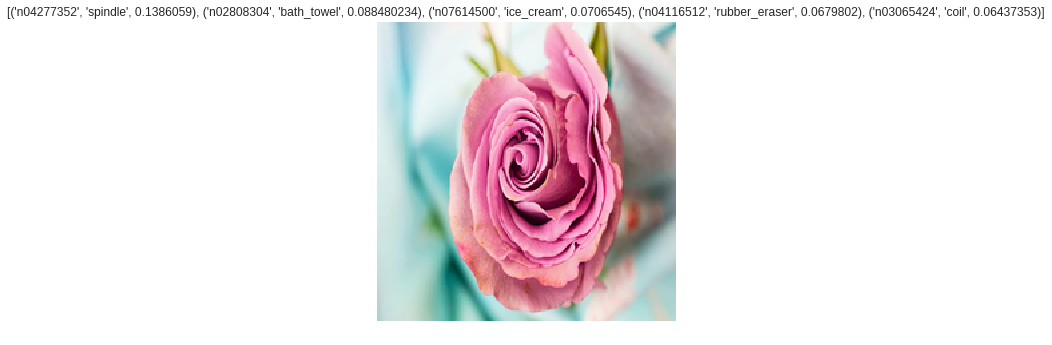

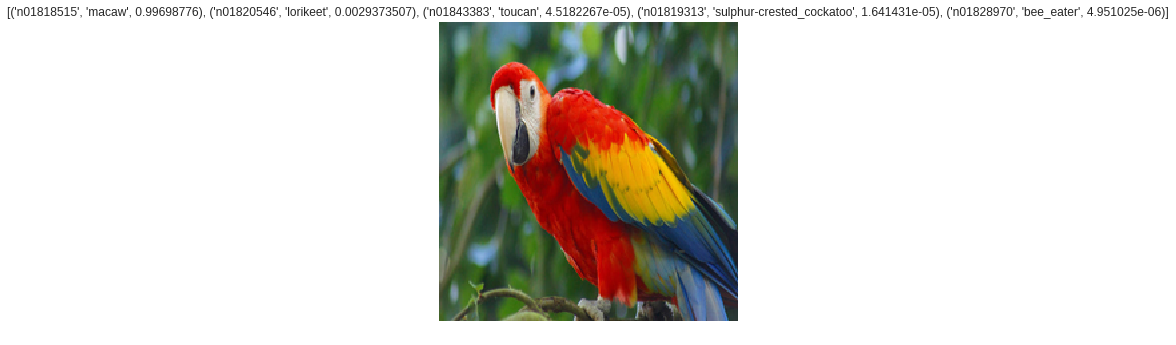

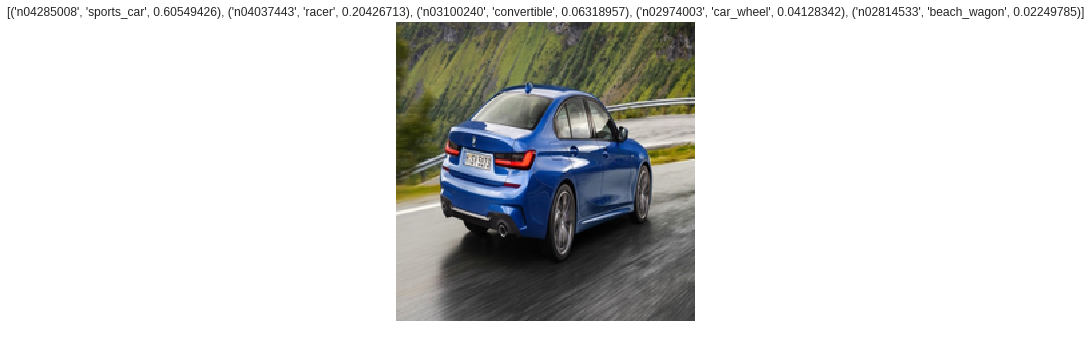

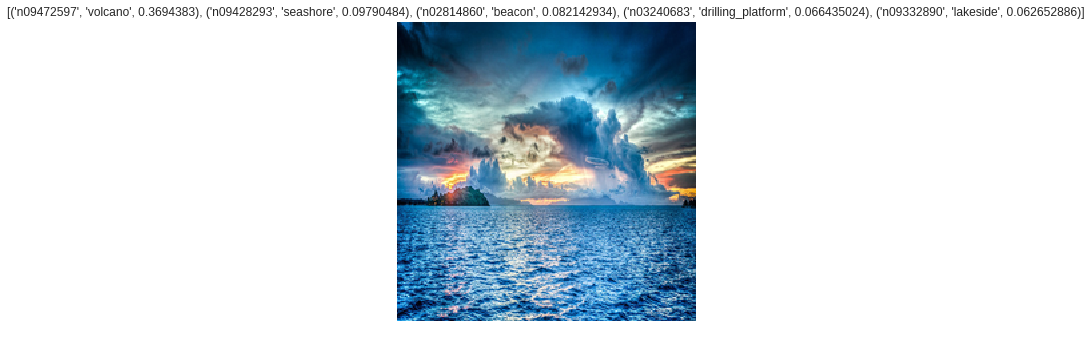

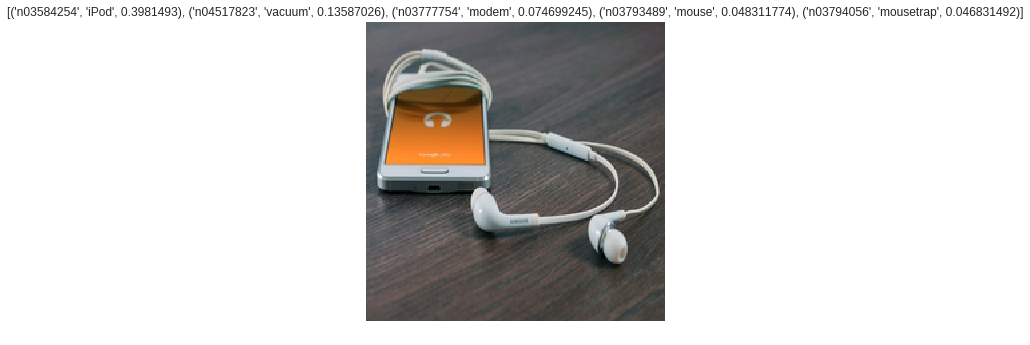

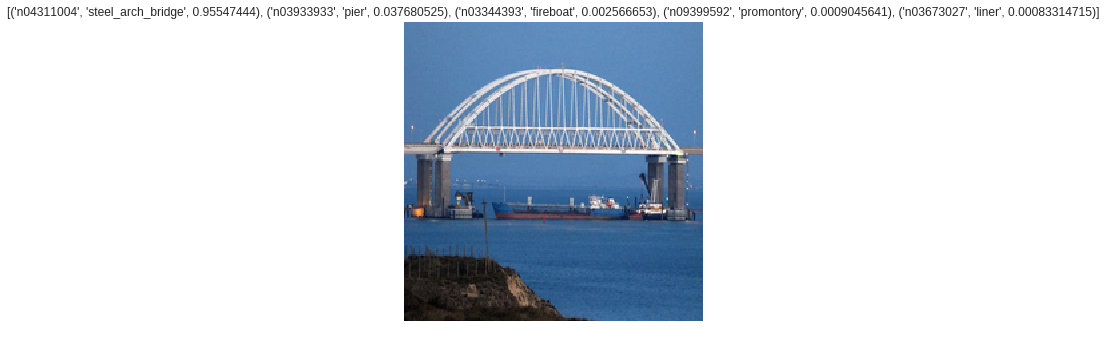

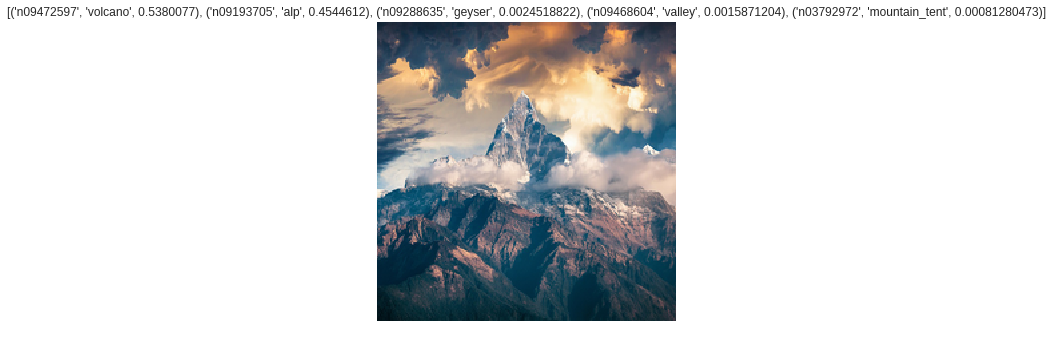

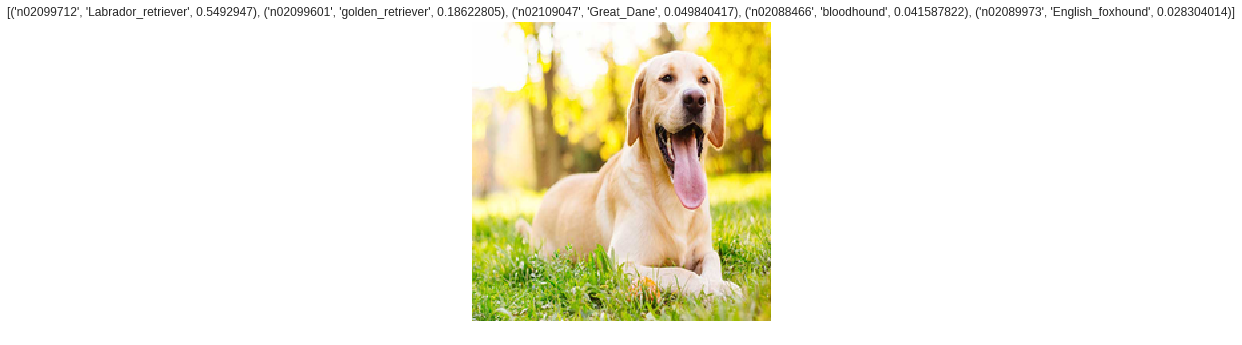

11/11 [==============================] - 32s 3s/step


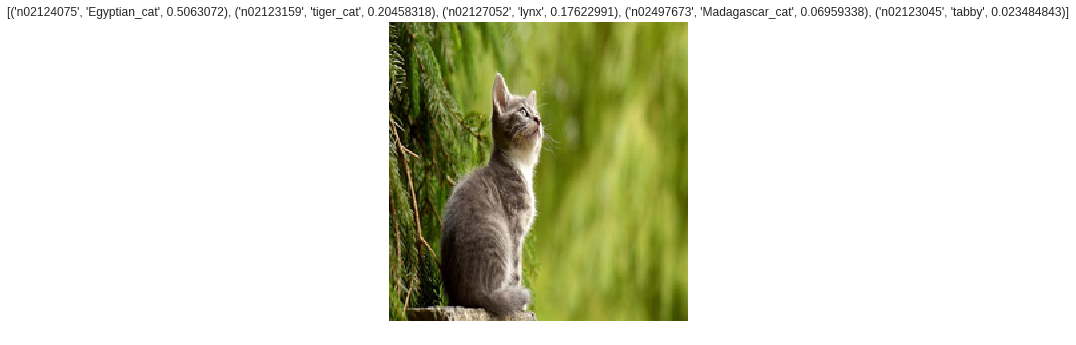

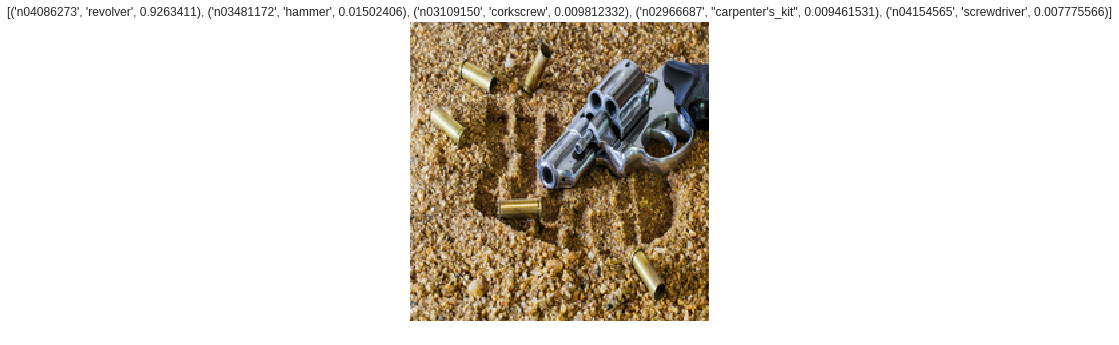

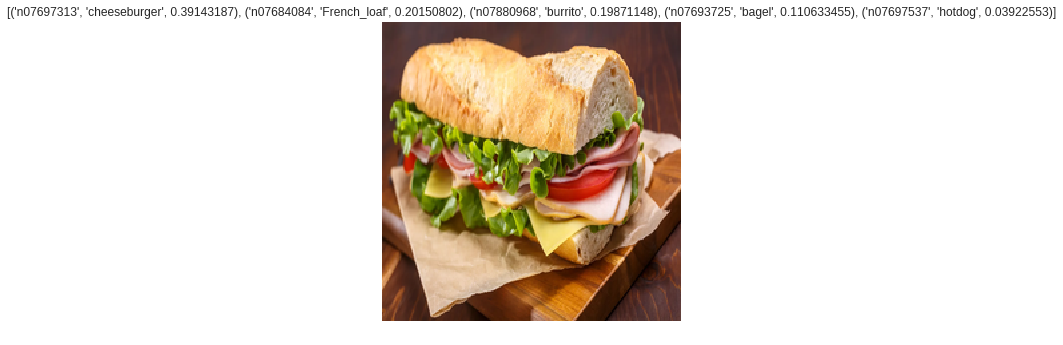

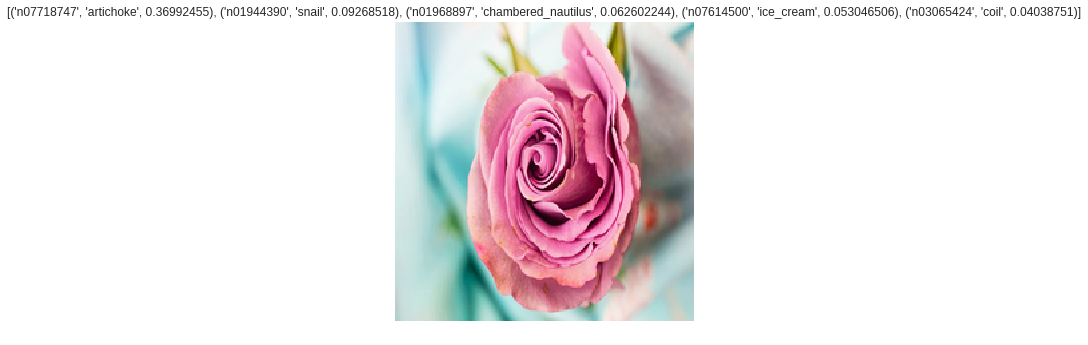

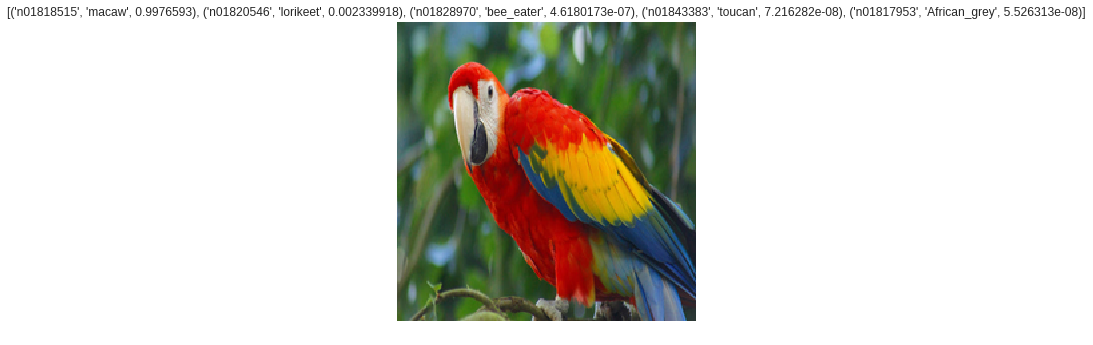

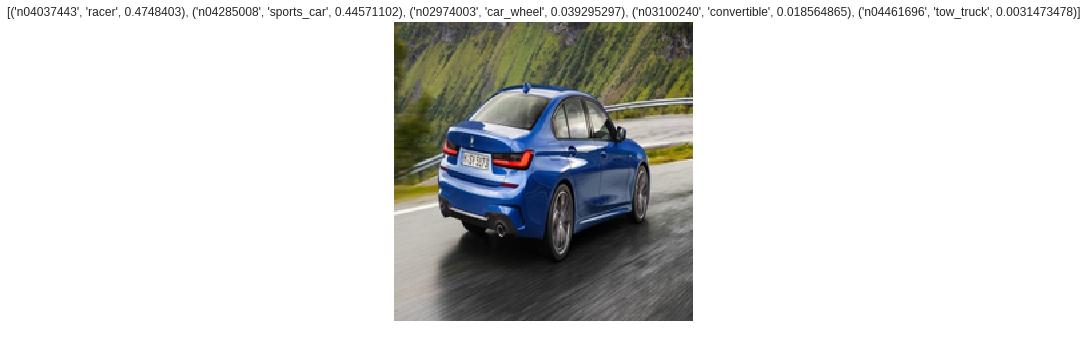

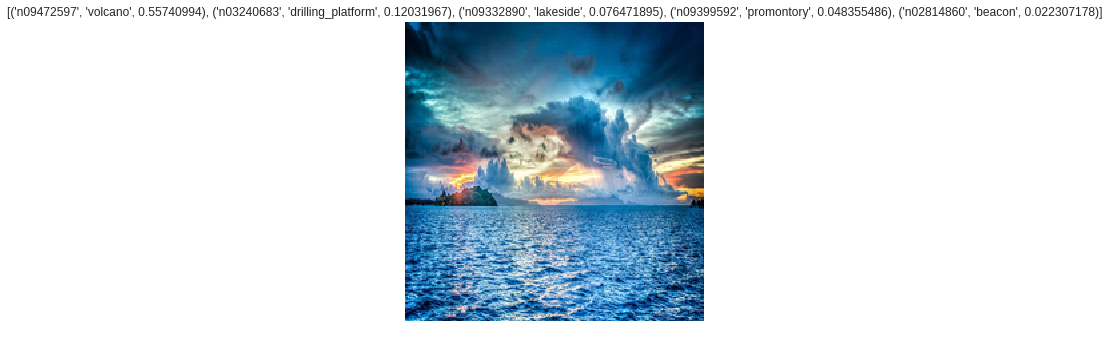

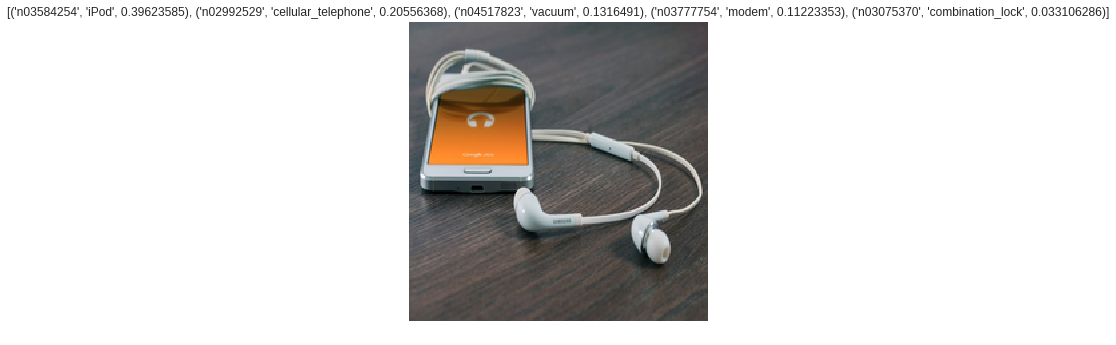

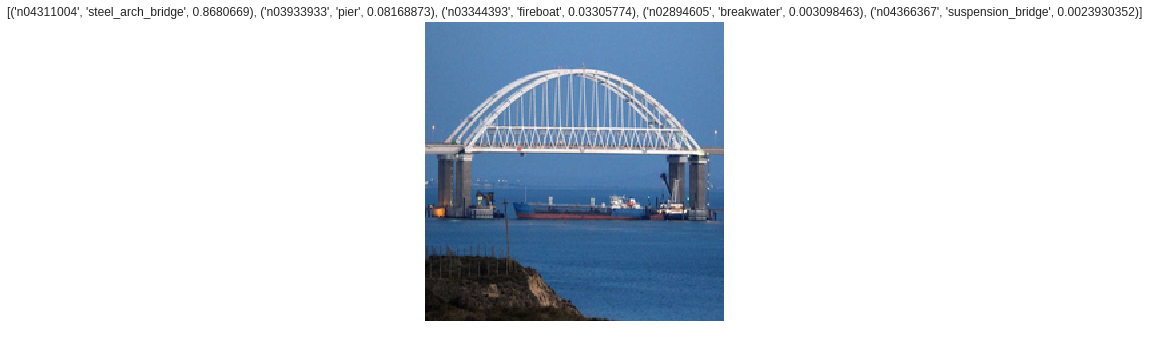

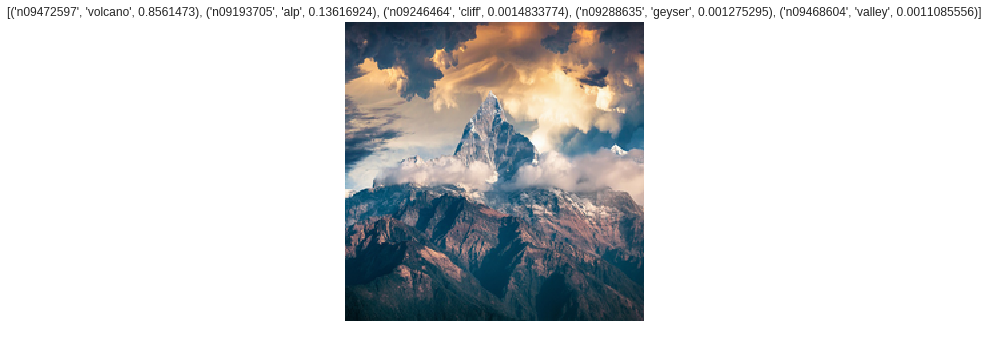

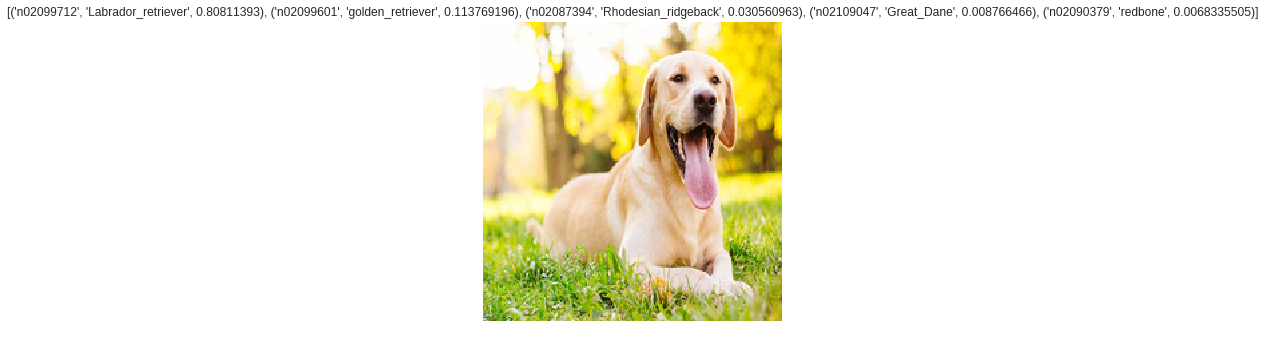

11/11 [==============================] - 28s 3s/step


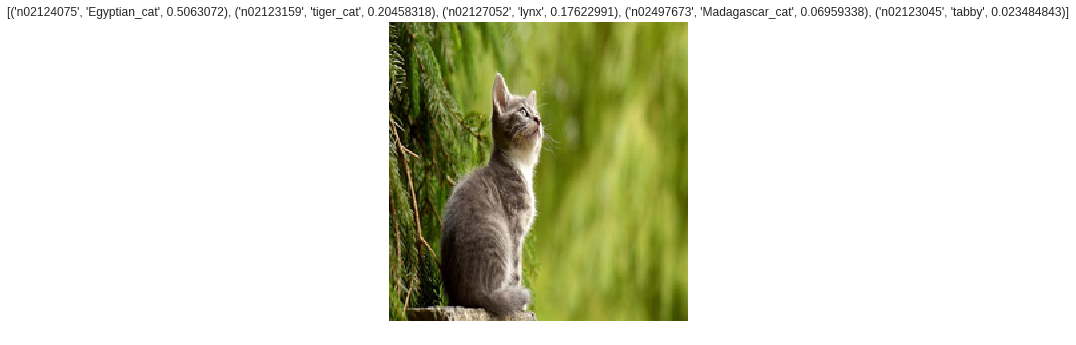

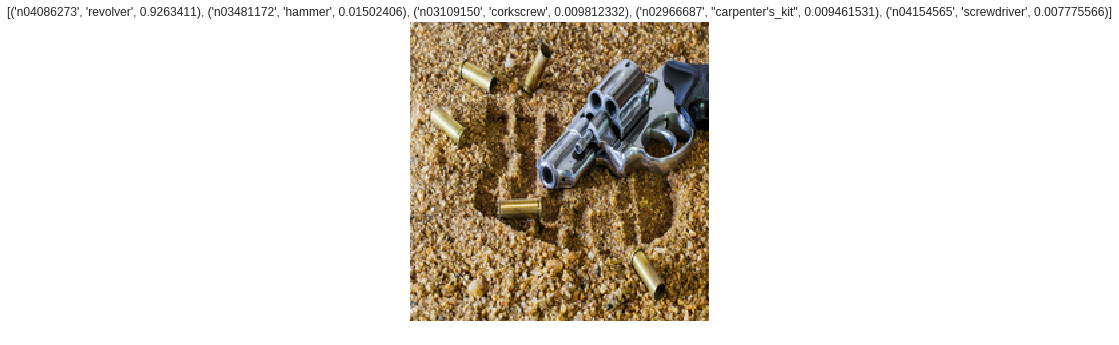

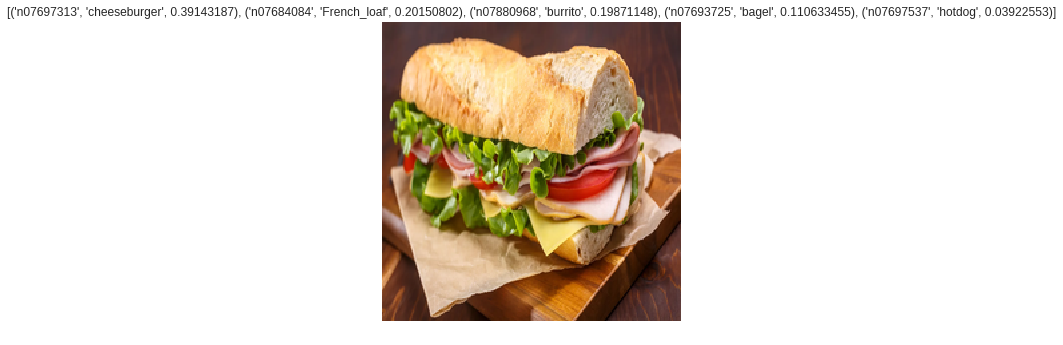

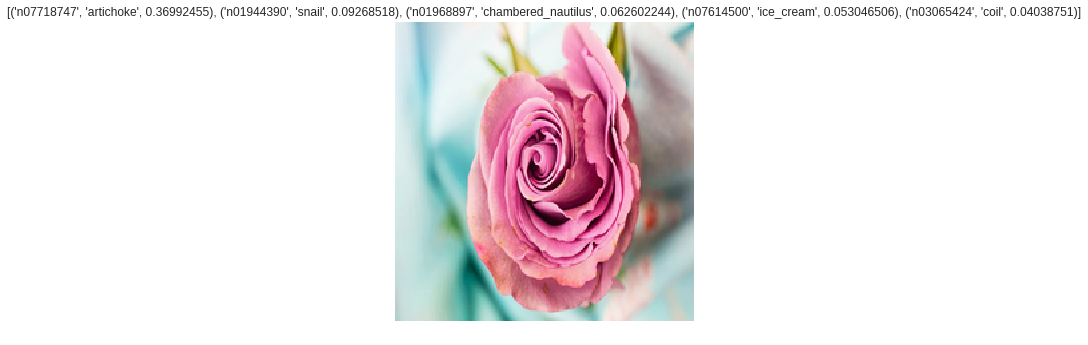

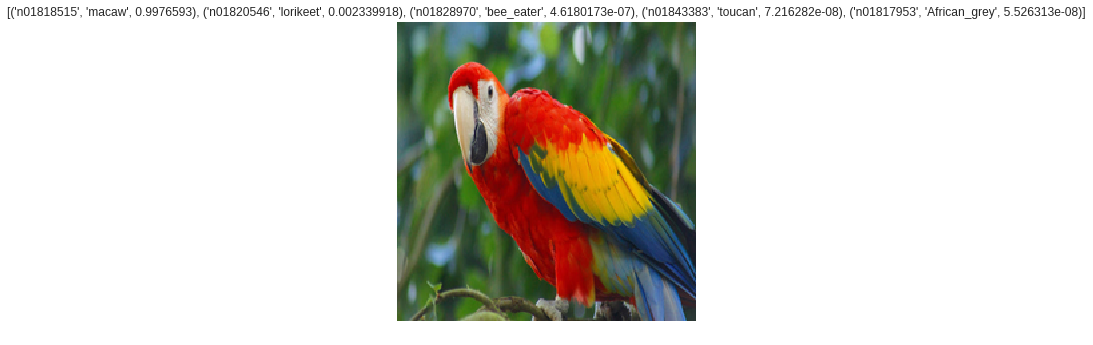

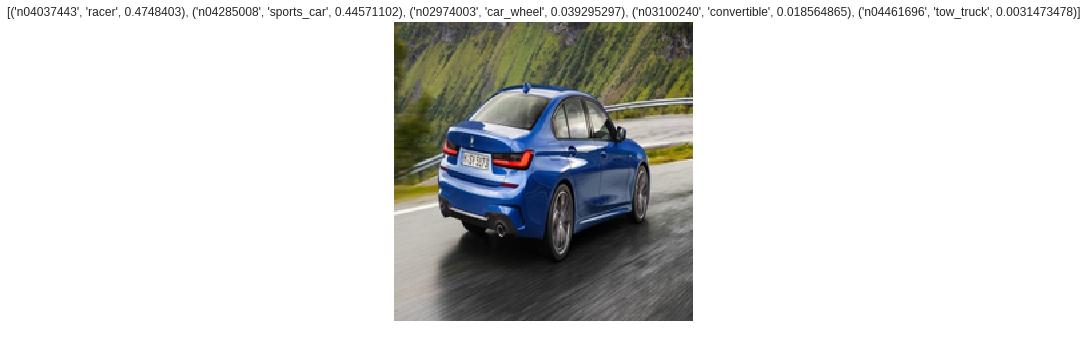

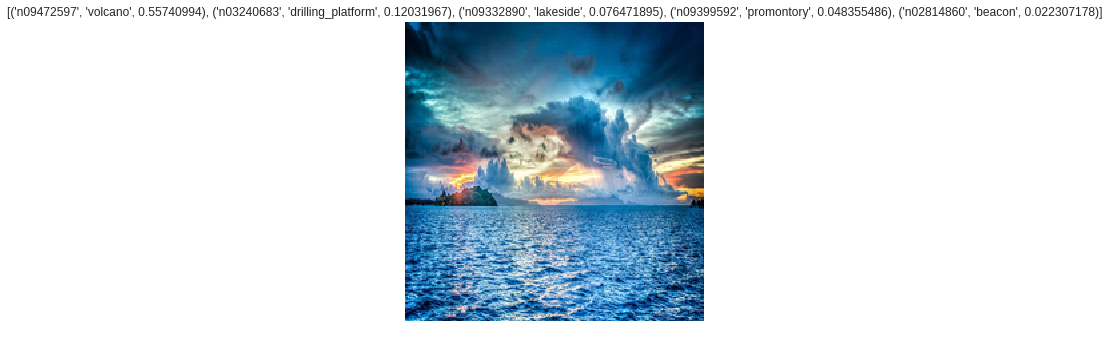

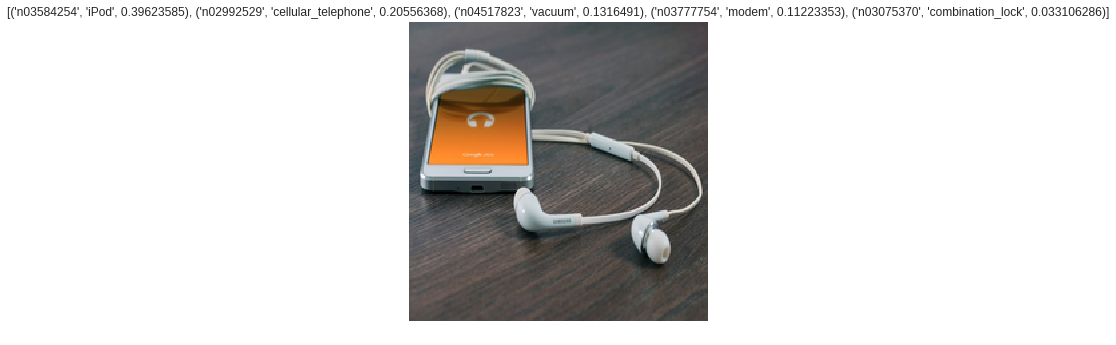

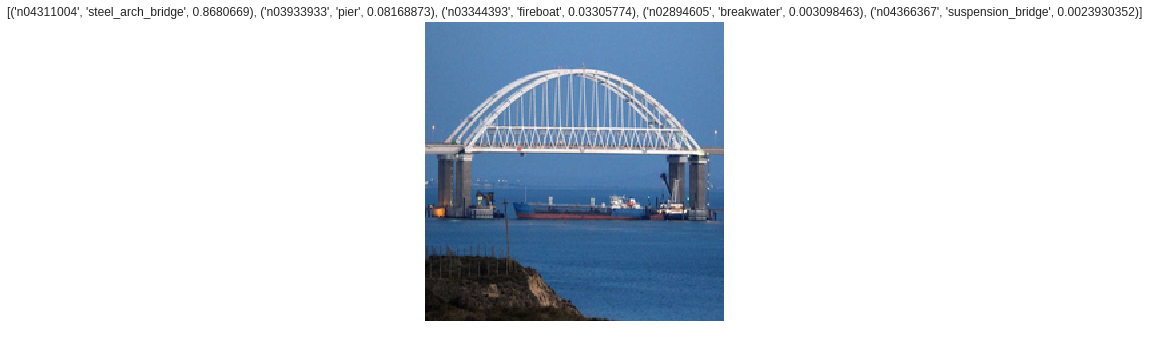

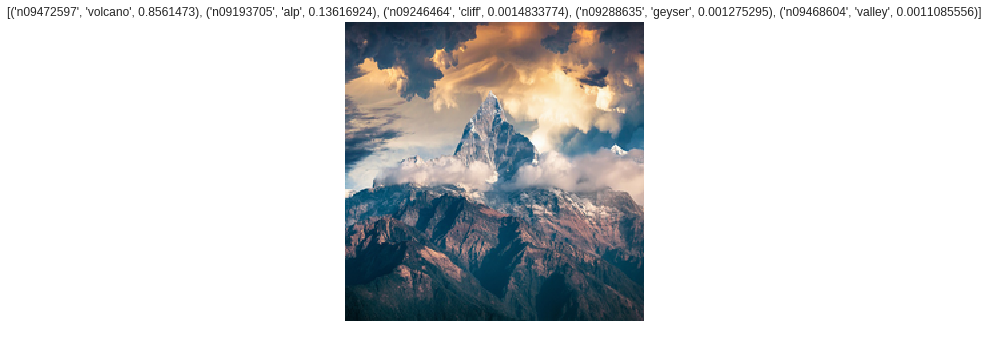

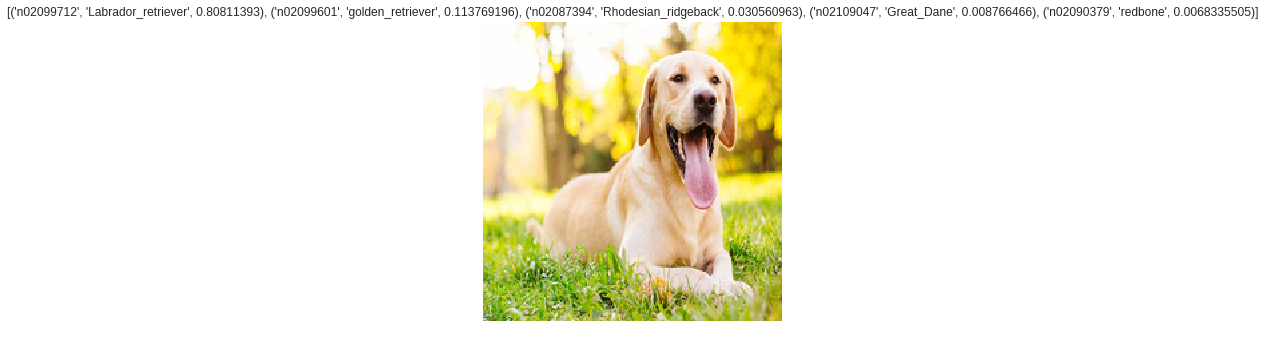

In [0]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.resnet50 import ResNet50
from keras.applications.densenet import DenseNet201

# models using 224x224 images

# VGG 16
predictedClassesVGG16 = classifyImages(preparedImages, VGG16(input_shape=(224, 224, 3)))
printResults(preparedImages, predictedClassesVGG16)

# VGG 19
predictedClassesVGG19 = classifyImages(preparedImages, VGG19(input_shape=(224, 224, 3)))
printResults(preparedImages, predictedClassesVGG19)

# MobileNetV2
predictedClassesMobileNetV2 = classifyImages(preparedImages, MobileNetV2(input_shape=(224, 224, 3)))
printResults(preparedImages, predictedClassesVGG19)

# ResNet
predictedClassesResNet50 = classifyImages(preparedImages, ResNet50(input_shape=(224, 224, 3)))
printResults(preparedImages, predictedClassesVGG19)

# DenseNet201
predictedClassesDenseNet201 = classifyImages(preparedImages, DenseNet201(input_shape=(224, 224, 3)))
printResults(preparedImages, predictedClassesVGG19)

# models using 299x299 images

# InceptionV3 (works only if image input is 299x299)
#predictClassesInceptionV3 = classifyImages(preparedImages, InceptionV3(input_shape=(299, 299, 3)))
#printResults(preparedImages, predictedClassesVGG19)


# Xception (works only if image input is 299x299)
#predictClassesXception = classifyImages(preparedImages, Xception(input_shape=(299, 299, 3)))
#printResults(preparedImages, predictedClassesVGG19)

#InceptionResNet (works only if image input is 299x299)
#predictClassesInceptionResNet = classifyImages(preparedImages, InceptionResNetV2(input_shape=(299, 299, 3)))
#printResults(preparedImages, predictedClassesVGG19)


## Modell Vergleich

In [13]:
# modelList1, resultsList1 for models with input size 224x224
# modelList2, resultList2 for models with input size 299x299

resultsList1 = [predictedClassesVGG16, predictedClassesVGG19, predictedClassesMobileNetV2, predictedClassesResNet50, predictedClassesDenseNet201]
#resultsList2 = [predictClassesInceptionV3, predictClassesXception, predictClassesInceptionResNet]

modelList1 = ['VGG16', 'VGG19', 'MobileNetV2', 'ResNet50', 'DenseNet201']
#modelList2 = ['InceptionV3', 'Xception', 'InceptionResNet']

# Diese Methode hier braucht 4 Parameter:
# 1. Die Liste der Dateinamen
# 2. Die Ergebnisse der einzelnen Modellen, als Array zusammengefasst
# 3. Die Namen der Modelle, einfach als String Array
# 4. Threshold (mind. Sicherheit der Modellvorhersage)

compareResults(foundFiles, resultsList1, modelList1, 0.05)
#compareResults(foundFiles, resultsList2, modelList2, 0.05)

Comparing the Results for File: /root/data/katze.jpg
 >  1 . Platz @  InceptionV3  :  ('n06359193', 'web_site', 0.97202617)
 >  1 . Platz @  Xception  :  ('n03942813', 'ping-pong_ball', 0.99158293)
 >  1 . Platz @  InceptionResNet  :  ('n06596364', 'comic_book', 1.0)
 >  2 . Platz @  InceptionV3  :  --- Threshold-Filter ---
 >  2 . Platz @  Xception  :  --- Threshold-Filter ---
 >  2 . Platz @  InceptionResNet  :  --- Threshold-Filter ---
 >  3 . Platz @  InceptionV3  :  --- Threshold-Filter ---
 >  3 . Platz @  Xception  :  --- Threshold-Filter ---
 >  3 . Platz @  InceptionResNet  :  --- Threshold-Filter ---
 >  4 . Platz @  InceptionV3  :  --- Threshold-Filter ---
 >  4 . Platz @  Xception  :  --- Threshold-Filter ---
 >  4 . Platz @  InceptionResNet  :  --- Threshold-Filter ---
 >  5 . Platz @  InceptionV3  :  --- Threshold-Filter ---
 >  5 . Platz @  Xception  :  --- Threshold-Filter ---
 >  5 . Platz @  InceptionResNet  :  --- Threshold-Filter ---

Comparing the Results for File: